## Extract and organize RNAseq data of CMV genes

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import StandardScaler
%matplotlib inline

#### General parameters

In [2]:
data_d = "/Users/erankotler/Google Drive/workspace/CMV/Data/RNAseq"
CMV_counts_matrix_f = os.path.join(data_d,"countsMatrix_normalized_CMV_genes.csv")
CMV_deseq_f = os.path.join(data_d,"de_stats_CMV_genes.csv")

#### Load and organize counts data

In [3]:
raw_df = pd.read_csv(CMV_counts_matrix_f)
raw_df.index = raw_df["Gene"]
raw_df.drop(["Unnamed: 0","Gene"], axis=1, inplace=True)

In [4]:
# Log transofrm by log(x+a) where a is a function of min. non-zero value
vals = np.unique(raw_df.values.flatten())
vals.sort()
min_non_zero = vals[1]
df = np.log10(raw_df+min_non_zero/10) # log transformation

#### Examine entire dataset

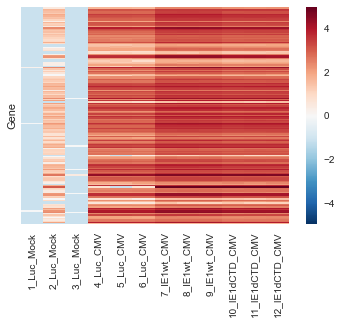

In [5]:
# Expression levels across all samples
sns.heatmap(df, yticklabels=False)
plt.show()

#### Remove No-CMV samples (all genes should be non-expressed here)

In [6]:
# Drop samples 1-3 (No CMV infection)
df.drop(["1_Luc_Mock", "2_Luc_Mock", "3_Luc_Mock"], axis=1, inplace=True)

#### inter-sample correlation

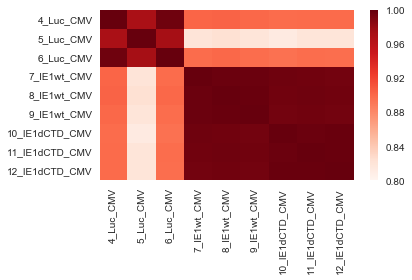

In [7]:
sns.heatmap(df.corr(), vmin=0.8, vmax=1, cmap="Reds")
plt.tight_layout()
plt.show()

#### Load DESeq diffrential expression data

In [43]:
deseq = pd.read_csv(CMV_deseq_f)
relevant_comparisons = ['IE1wt_CMV_vs_IE1dCTD_CMV','IE1wt_CMV_vs_Luc_CMV','IE1dCTD_CMV_vs_Luc_CMV'] # w/o Mock sample

In [46]:
de_data = deseq[deseq["pass"]=="yes"]

In [47]:
de_data.head()

,Comparison,Gene,baseMean,log2FoldChange,FoldChange,pvalue,padj,pass,Direction
1,IE1wt_CMV_vs_Luc_CMV,US7,119.8,2.597,6.0,1.980000e-48,6.730000e-47,yes,up
2,IE1wt_CMV_vs_Luc_Mock,US7,119.8,8.212,300.0,1.270000e-22,1.440000e-21,yes,up
3,IE1dCTD_CMV_vs_Luc_CMV,US7,119.8,1.896,3.7,2.000000e-25,3.330000e-24,yes,up
4,IE1dCTD_CMV_vs_Luc_Mock,US7,119.8,7.512,180.0,3.780000e-19,3.100000e-18,yes,up
5,Luc_CMV_vs_Luc_Mock,US7,119.8,5.616,49.0,3.930000e-11,3.830000e-10,yes,up


In [53]:
# list of genes that are DE in at least one comparison
de_genes = de_data[de_data["Comparison"].isin(relevant_comparisons)]["Gene"].unique()

# list of genes that are DE between IE1 & dCTD
de_genesIE1dCTD = de_data[de_data["Comparison"]=="IE1wt_CMV_vs_IE1dCTD_CMV"]["Gene"].unique()


#### Standardize rows (z-scores)

In [8]:
zdf = df.apply(lambda x:(x-x.mean())/x.std(), axis=1)

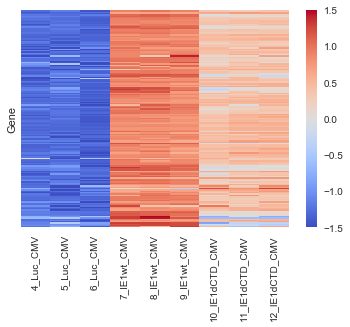

In [10]:
sns.heatmap(zdf, yticklabels=False,  vmin=-1.5, vmax=1.5, cmap="coolwarm")
plt.show()

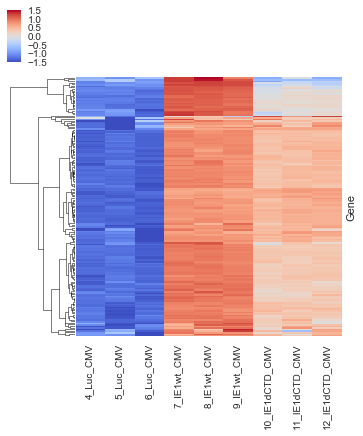

In [12]:
# Clustered heatmap (by rows)
sns.clustermap(df, yticklabels=False, vmin=-1.5, vmax=1.5, z_score=0, cmap="coolwarm", method="ward", 
               col_cluster=False, figsize=(6,6))
plt.show()

In [13]:
# Compare only IE1wt to IE1dCTD
IE1_zdf = zdf[["7_IE1wt_CMV", "8_IE1wt_CMV","9_IE1wt_CMV","10_IE1dCTD_CMV","11_IE1dCTD_CMV","12_IE1dCTD_CMV"]]

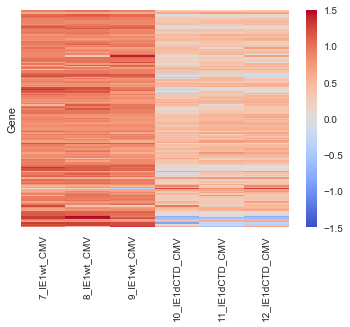

In [14]:
sns.heatmap(IE1_zdf, yticklabels=False,  vmin=-1.5, vmax=1.5, cmap="coolwarm")
plt.show()

In [15]:
# Create dataframe of means and fold changes for each gene (for sorting)
means_df = pd.DataFrame()
means_df.loc[:,"mean_IE1"] = IE1_zdf.loc[:, ["7_IE1wt_CMV", "8_IE1wt_CMV", "9_IE1wt_CMV"]].mean(axis=1)
means_df.loc[:,"mean_dCTD"] = IE1_zdf.loc[:, ["10_IE1dCTD_CMV", "11_IE1dCTD_CMV", "12_IE1dCTD_CMV"]].mean(axis=1)
means_df.loc[:,"logFC_IE1_dCTD"] = means_df.loc[:,"mean_IE1"] - means_df.loc[:,"mean_dCTD"]

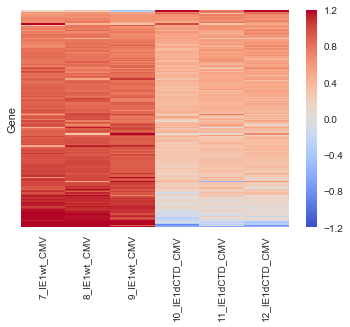

In [19]:
means_df.sort_values(by="logFC_IE1_dCTD", inplace=True)
sns.heatmap(IE1_zdf.loc[means_df.index], yticklabels=False,  vmin=-1.2, vmax=1.2, cmap="coolwarm")
plt.show()

In [60]:
# dCTD_up = means_df.head()
means_df[means_df["logFC_IE1_dCTD"]<0]

,mean_IE1,mean_dCTD,logFC_IE1_dCTD
Gene,,,
UL122,0.003488,1.109709,-1.106221
UL112,0.590104,0.738144,-0.148040
UL120,0.573816,0.678567,-0.104752
US8,0.644019,0.687349,-0.043330
UL123,0.643856,0.658806,-0.014950
US9,0.660998,0.670371,-0.009374


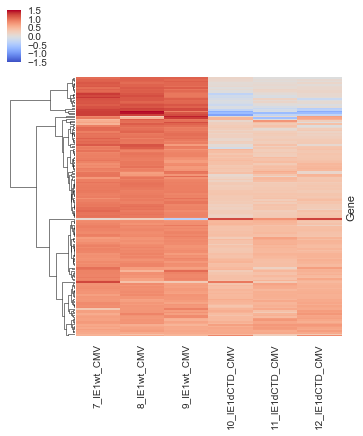

In [18]:
# Cluster using same values
cg = sns.clustermap(IE1_zdf, yticklabels=False, vmin=-0.2, vmax=1.5, cmap="coolwarm", method="ward", 
               col_cluster=False, figsize=(6,6))
plt.show()

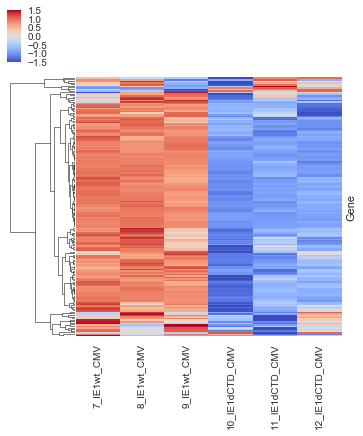

In [19]:
# Cluster with re-zscoring per row
cg = sns.clustermap(IE1_zdf, yticklabels=False, vmin=-1.5, vmax=1.5, z_score=0, cmap="coolwarm", method="ward", 
               col_cluster=False, figsize=(6,6))
plt.show()

In [20]:
# Extract genes in each cluster:
from scipy.cluster.hierarchy import fcluster
k=3 # number of clusters
Z= cg.dendrogram_row.linkage # dendrogram data
clusts = fcluster(Z, k, criterion='maxclust')
cluster_df = IE1_zdf.copy()
cluster_df.loc[:, "Cluster"]=np.array(clusts)
gene_dict={}
for i in range(1,k+1):
    gene_dict[i] = cluster_df[cluster_df["Cluster"]==i]
#     gene_dict[i].to_csv(os.path.join(output_analysis_dir,"Cluster_"+str(i)+".csv"))
#     print len(cluster_df[cluster_df["Cluster"]==i])
    print "cluster {cluster_num}: {N} genes".format(cluster_num = i, N = len(cluster_df[cluster_df["Cluster"]==i]))
# df.to_csv(os.path.join(output_analysis_dir,"All_genes.csv"))

cluster 1: 9 genes
cluster 2: 139 genes
cluster 3: 16 genes
